# Basic example for bssunfold package

In [1]:
# %pip install bssunfold pandas numpy matplotlib cvxpy ecos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bssunfold import Detector

## Load the response functions file for the BSS
- first column: Energy in MeV
- other columns: detector responses for the set of moderator spheres

In [3]:
# response functions default GSF
from bssunfold import RF_GSF
df = pd.DataFrame.from_dict(RF_GSF, orient='columns')
Detector_GSF = Detector(df)

In [4]:
# reference spectrum ISO Cf-252.
reference_spectrum = {
    "E_MeV": [
        1e-09,
        1.5848931924611136e-09,
        2.5118864315095803e-09,
        3.981071705534973e-09,
        6.309573444801934e-09,
        1e-08,
        1.5848931924611143e-08,
        2.511886431509581e-08,
        3.9810717055349736e-08,
        6.309573444801934e-08,
        1.0000000000000001e-07,
        1.5848931924611143e-07,
        2.5118864315095823e-07,
        3.9810717055349735e-07,
        6.309573444801937e-07,
        1.0000000000000002e-06,
        1.584893192461114e-06,
        2.5118864315095823e-06,
        3.981071705534973e-06,
        6.309573444801937e-06,
        1e-05,
        1.584893192461114e-05,
        2.5118864315095822e-05,
        3.9810717055349776e-05,
        6.309573444801943e-05,
        0.0001,
        0.00015848931924611142,
        0.0002511886431509582,
        0.0003981071705534978,
        0.0006309573444801943,
        0.001,
        0.0015848931924611143,
        0.0025118864315095825,
        0.003981071705534978,
        0.006309573444801942,
        0.01,
        0.01584893192461114,
        0.025118864315095826,
        0.039810717055349776,
        0.06309573444801943,
        0.1,
        0.15848931924611173,
        0.25118864315095824,
        0.3981071705534969,
        0.6309573444801944,
        1.0,
        1.5848931924611174,
        2.5118864315095824,
        3.9810717055349856,
        6.309573444801943,
        10.0,
        15.848931924611176,
        25.118864315095824,
        39.810717055349855,
        63.09573444801943,
        100.0,
        158.48931924611173,
        251.18864315095823,
        398.1071705534986,
        630.9573444801944,
    ],
    "Phi": [
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0002193244132568562,
        0.000922,
        0.0017977302145640818,
        0.0033934229230273556,
        0.00638236969883396,
        0.01212580290671056,
        0.0237,
        0.04468185467401807,
        0.0822779218679577,
        0.1450462719353082,
        0.2413649401952857,
        0.359,
        0.45221093414611185,
        0.4338707690763234,
        0.2708850368693928,
        0.0856762250762,
        0.00427,
        0.0004258199483775139,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    ],
}

In [5]:
# effective readings of the GSF BSS for the reference spectrum [reading per second]
readings = {
    "0in": 0.00037707623092440032,
    "2in": 0.0099964357249166195,
    "3in": 0.053668754395163297,
    "5in": 0.18417232269591507,
    "6in": 0.21968230880012038,
    "8in": 0.22007281510471705,
    "10in": 0.17214800127917887,
    "12in": 0.12033147452298382,
    "15in": 0.066744761746482972,
    "18in": 0.03411946184195816,
}

## Unfold the spectrum
1) Tikhonov regularization solded with CVXPY, ECOS solver
2) Landweber iterative unfolding
3) CVXPY results are used as initial guess for Landweber unfolding

In [6]:
result_cvxpy = Detector_GSF.unfold_cvxpy(readings, regularization=1e-4)

results = {
    "CVXPY": result_cvxpy,
    "Landweber": Detector_GSF.unfold_landweber(readings, max_iterations=3000),
    "CVXPY -> Landweber": Detector_GSF.unfold_landweber(
        readings, initial_spectrum=result_cvxpy["spectrum"], max_iterations=3000
    ),
}

Status: optimal
Objective value: 8.307264458127286e-05
Residual norm: 0.000000
Result saved with key: 20260120_143757_cvxpy
Result saved with key: 20260120_143757_Landweber
Result saved with key: 20260120_143757_Landweber


## Plot results

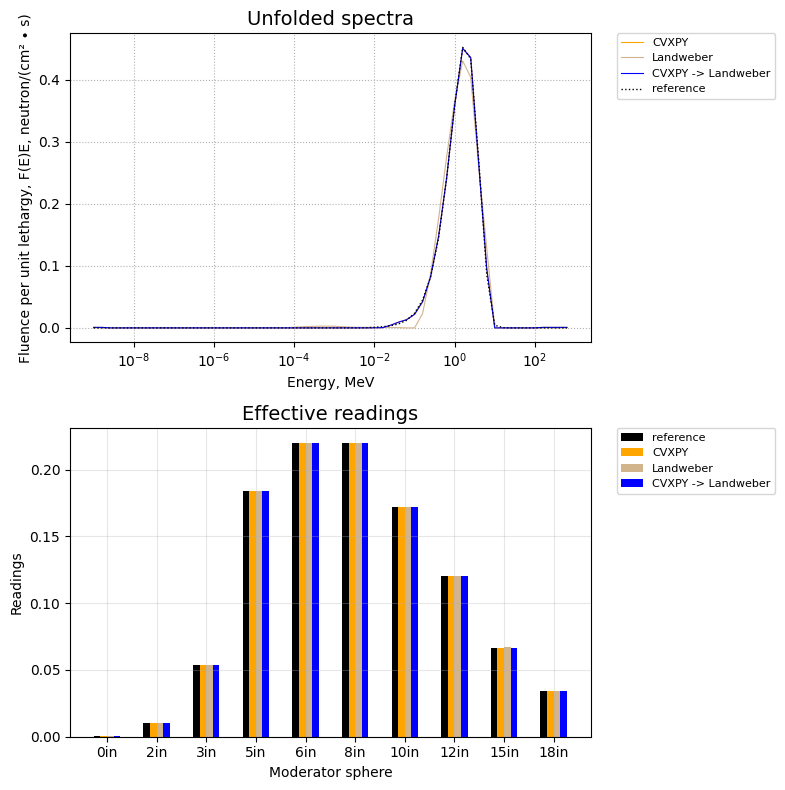

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
methods = list(results.keys())
all_labels = ["reference"] + methods

colors = ["black", "orange", "tan", "blue", "indianred"]
# Первый график (спектры)
for i, method in enumerate(results.keys()):
    ax[0].plot(
        results[method]["energy"],
        results[method]["spectrum"],
        label=method,
        color=colors[i + 1],
        ls="-",
        linewidth=0.8,
        alpha=1,
    )

ax[0].plot(
    reference_spectrum["E_MeV"],
    reference_spectrum["Phi"],
    label="reference",
    linewidth=1,
    linestyle=":",
    color=colors[0],
)

ax[0].set_xlabel("Energy, MeV")
ax[0].set_ylabel("Fluence per unit lethargy, F(E)E, neutron/(cm² ∙ s)")
ax[0].set_xscale("log")
ax[0].legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=8
)
ax[0].grid(True, which="both", ls=":")
ax[0].set_title(f"Unfolded spectra", fontsize=14)


# Второй график (столбчатая диаграмма)
data_sources = {"reference": list(readings.values())}
for method in results.keys():
    data_sources[method] = [
        results[method]["effective_readings"][det] for det in readings.keys()
    ]

labels = list(readings.keys())
x = np.arange(len(labels))
width = 0.8 / (len(data_sources) * 1.5)
n_bars = len(data_sources)

for i, (label, values) in enumerate(data_sources.items()):
    offset = (i - n_bars / 2 + 0.5) * width

    ax[1].bar(x + offset, values, width, label=label, alpha=1, color=colors[i])


ax[1].set_xticks(x, labels)
ax[1].set_xlabel("Moderator sphere")
ax[1].set_ylabel("Readings")
# ax[1].set_yscale('log')
ax[1].set_title("Effective readings", fontsize=14)
ax[1].legend(
    bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=8
)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Get the effective dose rates from unfolded spectrum for CVXPY in pcSv/s

In [8]:
print(results["CVXPY"]["doserates"])  # pcSv/s

{'AP': 334.88890577829125, 'PA': 196.50184663614039, 'LLAT': 149.40722188583499, 'RLAT': 129.37885020061367, 'ROT': 210.81456120800186, 'ISO': 169.30534736884704}
